# Übung 3: Retrieval Augmented Generation
In dieser Sitzung werden wir uns damit beschäftigen, wie wir die Leistungsfähigkeit von Large Language Models (LLMs) durch den Einsatz von Retrieval Augmented Generation (RAG) noch weiter steigern können. RAG ermöglicht es uns, LLMs mit externen Wissensquellen zu verbinden, um so präzisere und informativere Antworten auf unsere Fragen zu erhalten.

## Was ist RAG?
Stell dir vor, du hast einen super schlauen Freund, der viel liest und sich in vielen Themen auskennt. Wenn du ihn etwas fragst, kann er dir oft sehr gute Antworten geben. Aber manchmal weiß er auch nicht alles.

Retrieval Augmented Generation (RAG) ist wie ein solcher Freund, nur in digitaler Form. Es ist ein KI-System, das sehr gut darin ist, Texte zu verstehen und zu erzeugen. Aber im Gegensatz zu traditionellen LLM-Ansätzen beantwortet er die Fragen nicht aus trainiertem Wissen sondern kann auf eine Datenbank mit weiteren Informationen zugreifen.

**Wie funktioniert das?**

Du stellst eine Frage: Du gibst dem RAG-System eine Frage ein, zum Beispiel: "Was ist die Hauptstadt von Frankreich?"
1. Retrieval in Vektordatenbank: Das System sucht in einer riesigen Menge an Texten (wie zum Beispiel Wikipedia oder anderen Webseiten) nach Informationen, die zu deiner Frage passen.
2. Das System gibt eine Antwort: Anhand der gefundenen Informationen erstellt RAG eine Antwort für dich. In unserem Beispiel wäre die Antwort natürlich "Paris".

**Warum ist RAG so besonders?**

Bei Sprachmodellen kommt es häufig zu Halluzinationen. Das bedeutet, dass das Sprachmodell Dinge durcheinander bringt und sich Zusammenhänge ausdenkt, die gar nicht existieren.
Weil RAG auf aktuelle Informationen zugreifen kann, sind  Antworten oft genauer und relevanter als die von einem normalen Sprachmodell. Die relevanten Informationen werden direkt in die Prompt mitgegeben. Das RAG-System muss daher nicht aus eigenem Wissen antworten sondern kann auf die Daten aus der Prompt zugreifen.

## Setup

In [1]:
!pip install haystack-ai "sentence-transformers>=3.0.0" pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.0/380.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.3 MB/s eta 0:00:00


## Aufgabe

Überlege dir selbst einen passenden Use Case für ein RAG-System im Kontext Finanzen. Passe den Code entsprechend an.

## Document Pipeline
Um per RAG auf eine Datenbasis zugreifen zu können, müssen wir diese erst erstellen. Die Document Pipeline lädt die Inhalte analog zum Colab "Data Extraction" aus den zur Laufzeit angegebenen PDF-Dateien und lädt diese in eine lokale Vektordatenbank. Die Datenbasis kann anschließend mit der RAG-Pipeline abgefragt werden.

### Document Store
Hier wird die Vektordatenbank definiert, in der die eingelesenen Inhalte persistiert werden. Für dieses Lab nutzen wir einen sehr simple In-Memory Vektordatenbank.

In [2]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy
from haystack.components.writers import DocumentWriter

document_store = InMemoryDocumentStore()
document_writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE)

### Embeddings
In einer Vektordatenbank werden die Dokumenteninhalte mit einem Embedding abgelegt. Vereinfacht dargestellt fasst das Embedding den Inhalt des dazu abgelegten Dokumentes in Form eines Zahlenvektors zusammen.

Zur Erstellung der Embeddings werden auch KI-Modelle verwendet. In unserem Fall nutzen wir ein einfaches Modell von HuggingFace.

Bei der Suche nach relevanten Inhalten können dann auf Basis des Embeddings passende Textabschnitte gefunden werden. Ähnliche Textinhalte haben dabei ähnliche Embeddings.

In [3]:
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
doc_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")

### Pipeline
Die Pipeline ist wie folgt aufgebaut:
1. Einlesen der PDF-Dateien
2. Konvertierung der PDF-Dateien als Text
3. Erstellung der einzelnen Embeddings (s.o.)
4. Speichern der Inhalte mit den Embeddings in der Vektordatenbank

In [4]:
from haystack.components.fetchers import LinkContentFetcher

pdf_fetcher = LinkContentFetcher()

In [5]:
from haystack.components.converters import PyPDFToDocument

pdf_converter = PyPDFToDocument()

In [6]:
from haystack import Pipeline

document_pipeline = Pipeline()
document_pipeline.add_component("load_pdf", pdf_fetcher)
document_pipeline.add_component("convert_pdf", pdf_converter)
document_pipeline.add_component("embed_documents", doc_embedder)
document_pipeline.add_component("write_documents", document_writer)

document_pipeline.connect("load_pdf", "convert_pdf")
document_pipeline.connect("convert_pdf", "embed_documents")
document_pipeline.connect("embed_documents", "write_documents")

🚅 Components
  - load_pdf: LinkContentFetcher
  - convert_pdf: PyPDFToDocument
  - embed_documents: SentenceTransformersDocumentEmbedder
  - write_documents: DocumentWriter
🛤️ Connections
  - load_pdf.streams -> convert_pdf.sources (List[ByteStream])
  - convert_pdf.documents -> embed_documents.documents (List[Document])
  - embed_documents.documents -> write_documents.documents (List[Document])

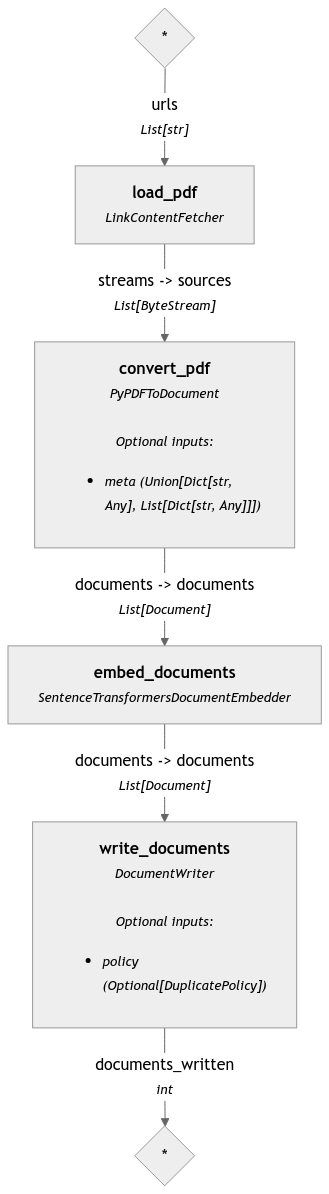

In [7]:
document_pipeline.show()

### Ausführen der Pipeline
Die Pipeline wird für die angegebenen URLs ausgeführt und die Inhalte in der Vektordatenbank hinterlegt.

In [8]:
from IPython.display import display, Markdown
url = ["https://www.realestate.bnpparibas.de/sites/default/files/document/2024-10/bnppre-bueroimmobilienmarkt-frankfurt-2024q3.pdf",
       "https://www.realestate.bnpparibas.de/sites/default/files/document/2024-10/bnppre-bueroimmobilienmarkt-muenchen-2024q3.pdf",
       "https://www.realestate.bnpparibas.de/sites/default/files/document/2024-01/bnppre-bueroimmobilienmarkt-dresden-2023q4.pdf"
       ]

result = document_pipeline.run(
        {
            "load_pdf": {"urls": url}
        }
    )
display(result["write_documents"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'documents_written': 3}

## RAG Pipeline
Die RAG-Pipeline nimmt eine Frage als Input und versucht diese auf Basis passender Informationen in der Vektordatenbank zu beantworten.

### Schritt 1 - Embedding für Frage erstellen
Um nach passenden Quellen in der Vektordatenbank suchen zu können, muss für die Frage zunächst ein Embedding erstellt werden. Dies geschieht analog der Logik in der Document Pipeline.

In [9]:
from haystack.components.embedders import SentenceTransformersTextEmbedder

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")

### Schritt 2 - Passende Dokumente suchen
Das Embedding der Frage wird mit den Embeddings der Dokumente verglichen und die Top 2-Ergebnisse zurückgegeben.

In [10]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

retriever = InMemoryEmbeddingRetriever(document_store)

### Schritt 3 - Prompt erstellen
Die Inhalte der identifiziernen Dokumente werden anschließend gemeinsam mit der Frage in eine Prompt eingefügt.

In [11]:
from haystack.components.builders import PromptBuilder

prompt_template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=prompt_template)

### Schritt 4 - Prompt an ein LLM schicken
Der generierte Prompt wird anschließend an ein Large Language Model (hier: gpt-4o) geschickt. Dieses LLM wird in diesem Schritt definiert.

In [12]:
import os
from getpass import getpass
from haystack import Pipeline
from haystack.components.generators import AzureOpenAIGenerator
from haystack.utils import Secret

azure_endpoint = "https://cofinpro-training-openai-studio.openai.azure.com/"
azure_deployment = "gpt-4o"


api_key = getpass("Enter OpenAI API key:")

generator = AzureOpenAIGenerator(
    azure_endpoint=azure_endpoint,
    azure_deployment=azure_deployment,
    api_key=Secret.from_token(api_key)
)

Enter OpenAI API key:··········


### Schritt 5 - Komponenten verknüpfen
In diesem Schritt werden die vorher definierten Komponenten in einer Pipeline miteinander verknüpft.

Bei Ausführung erhält die Pipeline eine Frage und führt anschließend alle definierten Schritte nacheinander durch.

In [13]:
rag_pipeline = Pipeline()

rag_pipeline.add_component("embed_query", text_embedder)
rag_pipeline.add_component("retrieve_documents", retriever)
rag_pipeline.add_component("build_prompt", prompt_builder)
rag_pipeline.add_component("generate_results", generator)

rag_pipeline.connect("embed_query.embedding", "retrieve_documents.query_embedding")
rag_pipeline.connect("retrieve_documents", "build_prompt.documents")
rag_pipeline.connect("build_prompt", "generate_results")

🚅 Components
  - embed_query: SentenceTransformersTextEmbedder
  - retrieve_documents: InMemoryEmbeddingRetriever
  - build_prompt: PromptBuilder
  - generate_results: AzureOpenAIGenerator
🛤️ Connections
  - embed_query.embedding -> retrieve_documents.query_embedding (List[float])
  - retrieve_documents.documents -> build_prompt.documents (List[Document])
  - build_prompt.prompt -> generate_results.prompt (str)

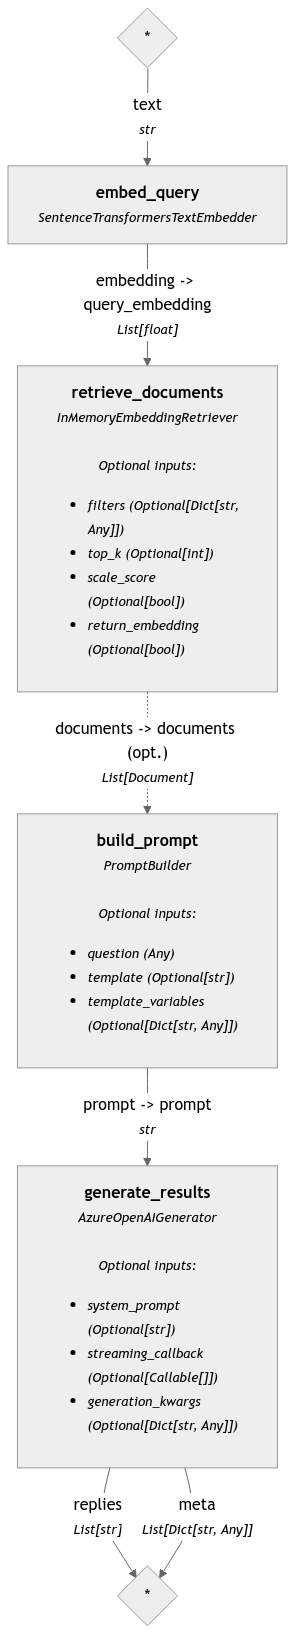

In [14]:
rag_pipeline.show()

### Schritt 6 - Ausführen der Pipeline
Die Pipeline wird mit der angegebene Frage ausgeführt und die Ergebnisse zurückgegeben.

In [15]:
question = "Wie ist die Marktentwicklung in Frankfurt?"

In [16]:
from IPython.display import display, Markdown

result = rag_pipeline.run(
        {
            "embed_query": {"text": question},
            "retrieve_documents": {"top_k": 2},
            "build_prompt": {"question": question}
        }
    )
display(Markdown(result["generate_results"]["replies"][0]))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Die Marktentwicklung in Frankfurt zeigt eine positive Tendenz. Trotz der Tatsache, dass der Büromarkt in den ersten drei Quartalen 2024 noch nicht an die überdurchschnittlichen Ergebnisse aus den Jahren bis 2022 anknüpfen konnte, spiegelt sich das insgesamt verbesserte Marktsentiment in einer Umsatzsteigerung von etwa 8 % gegenüber dem Vorjahreszeitraum wider. Der Flächenumsatz beläuft sich auf rund 307.000 m², was im Städtevergleich eine vergleichsweise geringe Abweichung von -14 % zum langjährigen Durchschnitt darstellt. Besonders bemerkenswert ist, dass Frankfurt der einzige Standort ist, der über dem 5-Jahresdurchschnitt notiert.

Die Nachfrage nach Büroflächen, insbesondere nach Premiumflächen und ESG-konformer Ausstattung, bleibt hoch, was sich in einer stabilen Spitzenmiete von 49,00 €/m² und einer Durchschnittsmiete von 24,20 €/m² ausdrückt. Die Leerstandsrate hat zwar um gut 13 % zugelegt und liegt aktuell bei 1,6 Mio. m², was einer Stabilisierung zum Vorquartal entspricht, doch der Markt zeigt eine hohe Nachfrage in zentralen und gut angebundenen Bürostandorten, insbesondere in der City, die rund 45 % des Gesamtergebnisses ausmacht.

Die Umsatzverteilung nach Branchen zeigt, dass der Finanzsektor (insbesondere durch den großen Abschluss der EZB) mit knapp 26 % des Umsatzes am stärksten beteiligt ist, gefolgt vom Handel (rund 17 %) und den Beratungsgesellschaften (gut 13 %). Im Segment großer Vertragsabschlüsse stechen vor allem die EZB (36.800 m²) und das Kosmetikunternehmen Cosnova (15.600 m²) hervor.

Die Perspektiven für den Frankfurter Büromarkt bleiben positiv, mit einem prognostizierten Flächenumsatz von etwa 450.000 m² bis Jahresende, was das Gesamtergebnis über dem Vorjahreswert, jedoch unterhalb des langjährigen Durchschnittswertes einordnen würde. Bei der Spitzenmiete und beim Leerstand wird für das Schlussquartal von stabilen Entwicklungen ausgegangen.